In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from timm.models.helpers import load_pretrained
from tqdm.autonotebook import tqdm

from models.t2t_vit import t2t_vit_14
from vit_shapley.modules.surrogate import Surrogate
from vit_shapley.modules.explainer_swin import Explainer
from datasets.CIFAR_10_Dataset import CIFAR_10_Dataset, CIFAR_10_Datamodule, PROJECT_ROOT, apply_masks_to_batch
from vit_shapley.masks import make_masks_from_player_values, get_distances_from_center
from utils import load_checkpoint
from shap_for_all import Shap_values

if torch.cuda.device_count() > 1:
    torch.cuda.set_device(5)

In [2]:
datamodule = CIFAR_10_Datamodule(num_players=4, num_mask_samples=1, paired_mask_samples=False, num_workers=0)
datamodule.setup()
data = next(iter(datamodule.train_dataloader()))

images = data['images']
labels = data['labels']
masks = data['masks']
print(images.shape, labels.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 1, 4])


# Loading models

In [3]:
surrogate_t2t_vit = Surrogate.load_from_checkpoint(
    PROJECT_ROOT / "saved_models/surrogate/cifar10/_t2t_vit_player16_lr0.0001_wd0.0_b256_epoch19.ckpt",
    backbone_name='t2t_vit',
    strict=False)

surrogate_vit = Surrogate.load_from_checkpoint(
    PROJECT_ROOT / "saved_models/surrogate/cifar10/_vit_player16_lr0.0001_wd0.0_b256_epoch19.ckpt",
    backbone_name='vit',
    strict=False)

surrogate_swin = Surrogate.load_from_checkpoint(
    PROJECT_ROOT / "saved_models/surrogate/cifar10/_swin_player16_lr0.0001_wd0.0_b256_epoch19.ckpt",
    backbone_name='swin',
    strict=False)

pass

adopt performer encoder for tokens-to-token


/home/ubuntu/.conda/envs/main/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['target_model.cls_token', 'target_model.pos_embed', 'target_model.tokens_to_token.attention1.w', 'target_model.tokens_to_token.attention1.kqv.weight', 'target_model.tokens_to_token.attention1.kqv.bias', 'target_model.tokens_to_token.attention1.proj.weight', 'target_model.tokens_to_token.attention1.proj.bias', 'target_model.tokens_to_token.attention1.norm1.weight', 'target_model.tokens_to_token.attention1.norm1.bias', 'target_model.tokens_to_token.attention1.norm2.weight', 'target_model.tokens_to_token.attention1.norm2.bias', 'target_model.tokens_to_token.attention1.mlp.0.weight', 'target_model.tokens_to_token.attention1.mlp.0.bias', 'target_model.tokens_to_token.attention1.mlp.2.weight', 'target_model.tokens_to_token.attention1.mlp.2.bias', 'target_model.tokens_to_token.attention2.w', 'target_model.tokens_to_token.atten

In [4]:
surrogate_t2t_vit_prob = torch.nn.Sequential(
    surrogate_t2t_vit,
    torch.nn.Softmax(dim=1),
)
surrogate_t2t_vit.eval()

surrogate_vit_prob = torch.nn.Sequential(
    surrogate_vit,
    torch.nn.Softmax(dim=1),
)
surrogate_vit.eval()

surrogate_swin_prob = torch.nn.Sequential(
    surrogate_swin,
    torch.nn.Softmax(dim=1),
)
surrogate_swin.eval()

pass

# Shap values visualization

## Ground truth for all three models

In [5]:
Shap_vs = Shap_values(surrogate_t2t_vit_prob, images, labels,
                          num_players=16)

shap_values_t2t_vit = Shap_vs.shap_values()

Shap_vs = Shap_values(surrogate_vit_prob, images, labels,
                          num_players=16)

shap_values_vit = Shap_vs.shap_values()

Shap_vs = Shap_values(surrogate_swin_prob, images, labels,
                          num_players=16)

shap_values_swin = Shap_vs.shap_values()

compute shapley values: 100%|██████████████████████████████████████████████████| 16/16 [00:29<00:00,  1.87s/it]


In [6]:
# Take only shapley values for the targets
shap_values_t2t_vit_ = shap_values_t2t_vit[torch.arange(shap_values_t2t_vit.shape[0]), :, labels]

shap_values_vit_ = shap_values_vit[torch.arange(shap_values_vit.shape[0]), :, labels]

shap_values_swin_ = shap_values_swin[torch.arange(shap_values_swin.shape[0]), :, labels]

In [23]:
# Test of axiom property: sum of shapley values is v(1) - v(0) in the coalitional game

def check_axiom(surrogate_model, shap_values):
    scores = surrogate_model(images.cuda())[torch.arange(images.shape[0]), labels]
    scores_zero = surrogate_model(torch.zeros(32, 3, 224, 224).cuda())[torch.arange(images.shape[0]), labels]
    scores_zero.shape
    
    diff = (scores - scores_zero).cpu()
    
    sum_shap = torch.sum(shap_values, dim=1)
    
    # Check whether shapley values sum up to the proper value
    print(torch.sum(abs(diff-sum_shap)) < 0.001)

surrogate_models = [surrogate_vit_prob, surrogate_t2t_vit_prob, surrogate_swin_prob]
shap_values_ = [shap_values_vit_, shap_values_t2t_vit_, shap_values_swin_]

for surrogate_model, shap_values in zip(surrogate_models, shap_values_):
    check_axiom(surrogate_model, shap_values)

tensor(True)
tensor(True)
tensor(False)


## Explainer shapley values for three models
- vit
- t2t_vit
- swin

In [30]:
explainers = dict()

explainer_paths = [PROJECT_ROOT / "saved_models/explainer/vit_freeze_none_use_surgTrue_player16_lr0.0001_wd0.0_b128.ckpt",
                   PROJECT_ROOT / "saved_models/explainer/t2t_vit_freeze_none_use_surgTrue_player16_lr0.0001_wd0.0_b128.ckpt",
                   PROJECT_ROOT / "saved_models/explainer/swin_freeze_none_use_surgTrue_player16_lr0.0001_wd0.0_b128.ckpt"]
                   
surrogate_models = {'vit': surrogate_vit,
                    't2t_vit': surrogate_t2t_vit,                    
                    'swin': surrogate_swin}

model_names = ['vit', 't2t_vit', 'swin']
                   
for model_name, explainer_path in zip(model_names, explainer_paths):
    explainers[model_name] =  Explainer.load_from_checkpoint(
        explainer_path,
        map_location="cuda",
        surrogate=deepcopy(surrogate_models[model_name]),
        strict=False
    )
    explainers[model_name].eval()
    pass

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adopt performer encoder for tokens-to-token


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
from datasets.CIFAR_10_Dataset import _tensor_to_image, _make_image_grid
import PIL.Image

def get_heatmaps(values: torch.Tensor, images_shape: tuple[int, int, int, int], vmin: float = None, vmax: float = None) -> list[PIL.Image.Image]:
    """
    Args:
    - values: (B, num_players)
    - images_shape: (B, C, H, W)
    """
    B, num_players = values.shape
    _B, C, H, W = images_shape
    assert B == _B and C == 3, f"Shape mismatch {shap_values.shape=}, {images_shape=}"
    # print(values.min(), values.max())

    mask_H = int(np.round(np.sqrt(num_players)))
    mask_W = mask_H
    assert mask_H * mask_W == num_players, f"{num_players=}, expected a square number."
    values = values.view(B, mask_H, mask_W)

    # Upscale masks to image size.
    h_repeats, w_repeats = int(np.ceil(H / mask_H)), int(np.ceil(W / mask_W))
    values = values.repeat_interleave(h_repeats, dim=1).repeat_interleave(w_repeats, dim=2)
    values = values[:, :H, :W]

    if vmin is None:
        # vmin = values.min()
        vmin = values.min(dim=2, keepdim=True)[0].min(dim=1, keepdim=True)[0]
    if vmax is None:
        # vmax = values.max()
        vmax = values.max(dim=2, keepdim=True)[0].max(dim=1, keepdim=True)[0]
    values = (values - vmin) / (vmax - vmin + 1e-8)  # Normalize to [0, 1]

    color_map = plt.get_cmap('viridis')
    values = color_map(values)  # (B, H, W, 4)
    values = values[:, :, :, :3]  # Remove alpha channel
    values = torch.tensor(values).permute(0, 3, 1, 2)  # (B, C, H, W)

    # values = values.unsqueeze(dim=1).expand(-1, 3, -1, -1)  # Add C dimension
    # Masks now have shape (B, 1, H, W)

    return [_tensor_to_image(v, scale=0.5, mean=0, std=1) for v in values]

In [32]:
# heatmap_grid = _make_image_grid(get_heatmaps(shap_values, images.shape))
image_grid = CIFAR_10_Dataset.to_image_grid(images, labels, scale=0.5)
# PIL.Image.blend(image_grid, heatmap_grid, alpha=0.6)

Heatmaps for explainer are: 
For the model vit the heatmap is: 


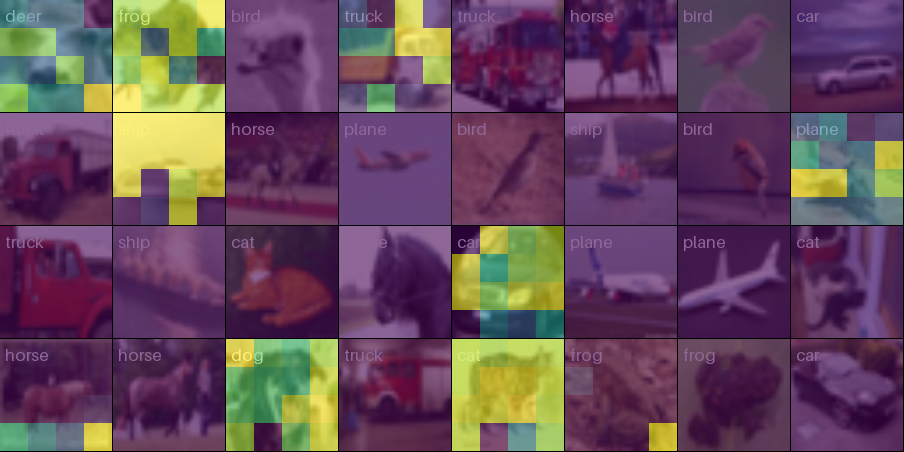

For the model t2t_vit the heatmap is: 


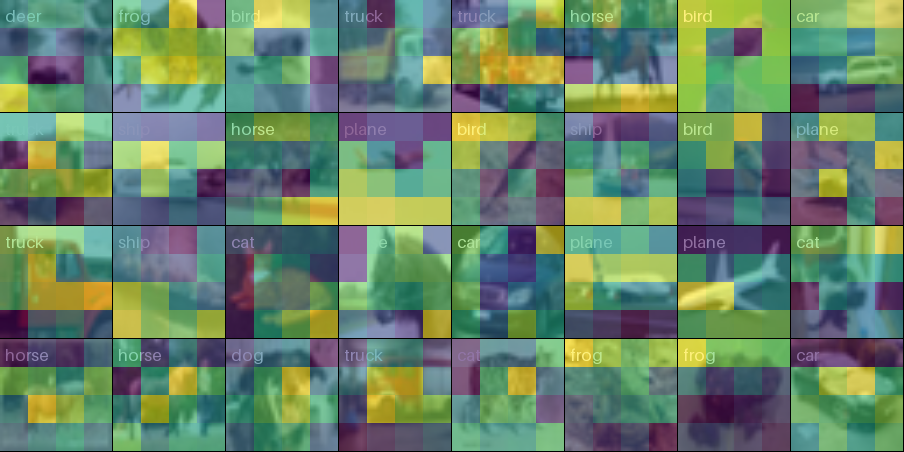

For the model swin the heatmap is: 


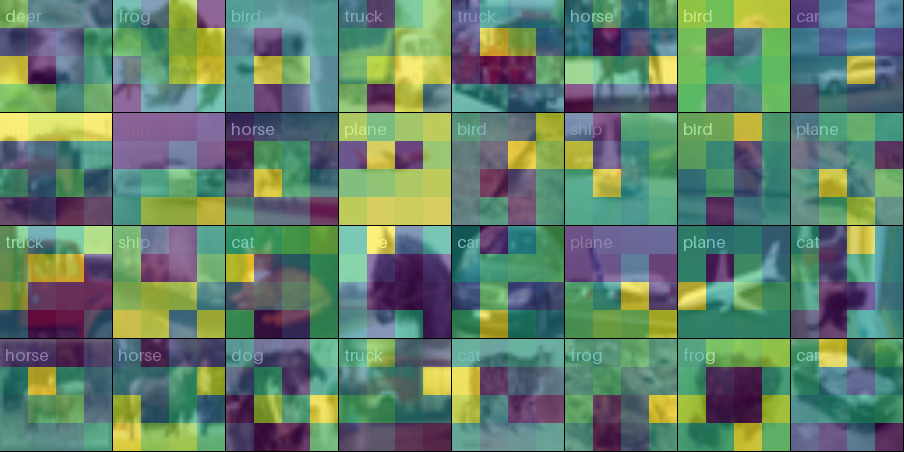

In [37]:
shap_values_explainer = dict()
print(f'Heatmaps for explainer are: ')
with torch.no_grad():
    for name in model_names:
        print(f"For the model {name.split('__')[0]} the heatmap is: ")
        explainer = explainers[name]
        shap_values_explainer_ = explainer(images.to(explainer.device)).cpu() 
        # (batch=32, num_players=196, num_classes=10)
        shap_values_explainer[name] = shap_values_explainer_[torch.arange(shap_values_explainer_.shape[0]), :, labels]
        # (batch, num_players)
    
        heatmap = _make_image_grid(get_heatmaps(shap_values_explainer[name], images.shape))
        PIL.Image.blend(image_grid, heatmap, alpha=0.6).show()
    

## Check the axiom property

In [38]:
shap_values_explainer['vit'].shape

torch.Size([32, 16])

In [41]:
surrogate_models = [surrogate_vit_prob, surrogate_t2t_vit_prob, surrogate_swin_prob]
shap_values_ = [shap_values_explainer['vit'], shap_values_explainer['t2t_vit'], shap_values_explainer['swin']]
                
for surrogate_model, shap_values in zip(surrogate_models, shap_values_):
    check_axiom(surrogate_model, shap_values)

tensor(True)
tensor(True)
tensor(True)


## Check correlations between each two models

In [42]:
import seaborn as sns

def plot_correlations(model_name_0, model_name_1):
    shap_values_explainer_0 = shap_values_explainer[model_name_0].view(-1).cpu().tolist()
    shap_values_explainer_1 = shap_values_explainer[model_name_1].view(-1).cpu().tolist()
    
    data = pd.DataFrame(list(zip(shap_values_explainer_0, shap_values_explainer_1)),
                   columns =[model_name_0, model_name_1])


    sns.regplot(x=model_name_0, 
                y=model_name_1,
                data = data).set(title=f'{model_name_0} against {model_name_1}')


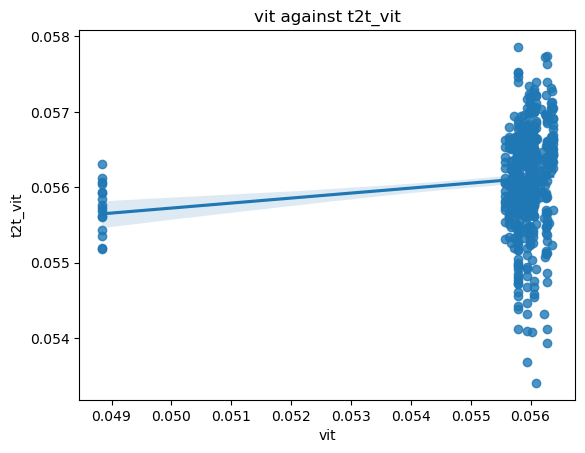

In [43]:
plot_correlations(model_names[0], model_names[1])

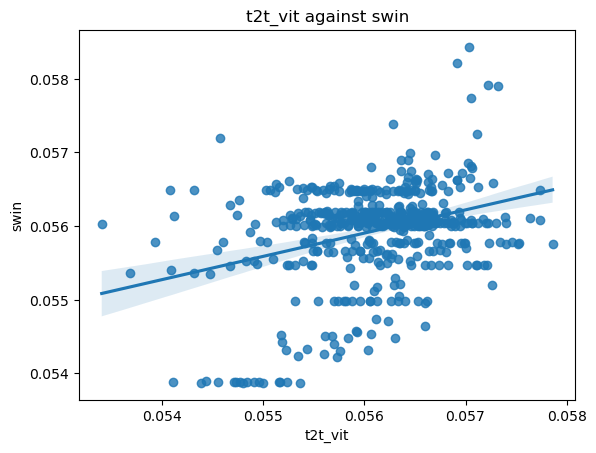

In [44]:
plot_correlations(model_names[1], model_names[2])

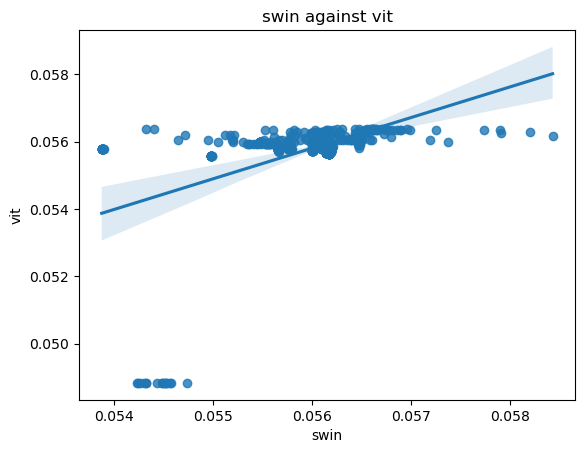

In [45]:
plot_correlations(model_names[2], model_names[0])

## Explainers against ground truth Shapley values

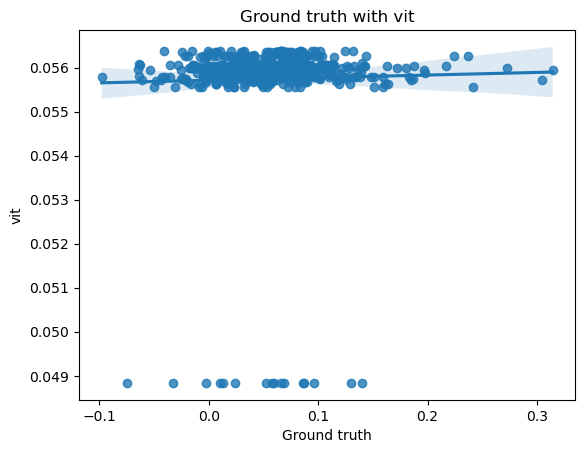

In [55]:
shap_values_vit_gt = shap_values_vit_.view(-1).cpu().tolist()

shap_values_explainer_ = shap_values_explainer[name].view(-1).cpu().tolist()
data = pd.DataFrame(list(zip(shap_values_vit_gt, shap_values_explainer['vit'].view(-1).cpu().tolist())),
               columns =['Ground truth', 'vit'])
    
sns.regplot(x='Ground truth', y='vit', data=data).set(title='Ground truth with vit')

plt.show()
plt.clf()
plt.close()

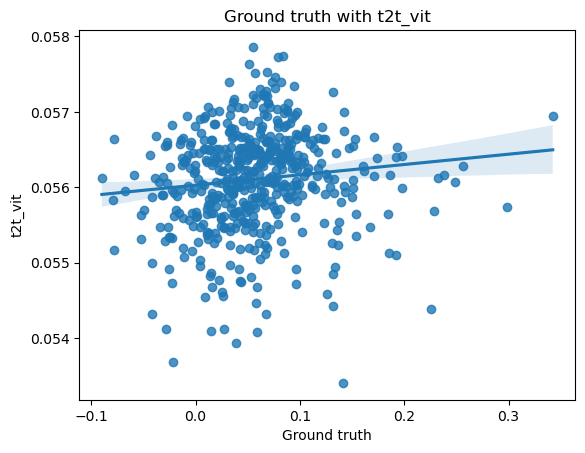

In [56]:
shap_values_t2t_vit_gt = shap_values_t2t_vit_.view(-1).cpu().tolist()

# fig, ax = plt.subplots(3, 1, sharex=True, figsize=(9,15))

# for i, name in enumerate(model_names[3:]):
shap_values_explainer_ = shap_values_explainer[name].view(-1).cpu().tolist()
data = pd.DataFrame(list(zip(shap_values_t2t_vit_gt, shap_values_explainer['t2t_vit'].view(-1).cpu().tolist())),
               columns =['Ground truth', 't2t_vit'])
    
sns.regplot(x='Ground truth', y='t2t_vit', data=data).set(title='Ground truth with t2t_vit')

plt.show()
plt.clf()
plt.close()

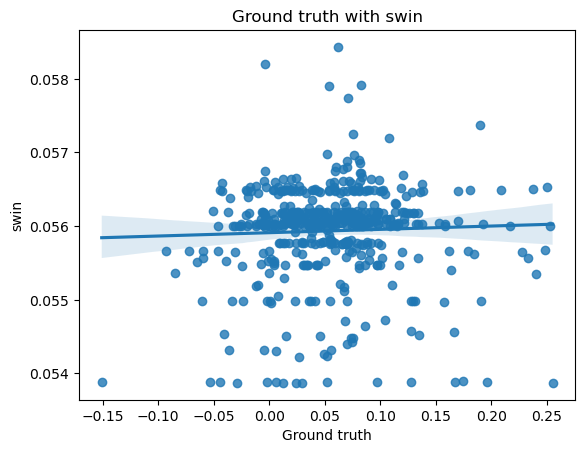

In [57]:
shap_values_swin_gt = shap_values_swin_.view(-1).cpu().tolist()

data = pd.DataFrame(list(zip(shap_values_swin_gt, shap_values_explainer['swin'].view(-1).cpu().tolist())),
               columns =['Ground truth', 'swin'])
    
sns.regplot(x='Ground truth', y='swin', data=data).set(title='Ground truth with swin')

plt.show()
plt.clf()
plt.close()

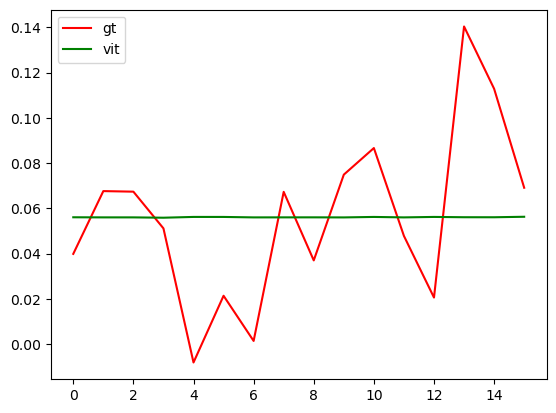

In [62]:
# vit
xpoints = np.array(range(16))
ypoints_0 = shap_values_vit_[0].numpy()

plt.plot(xpoints, ypoints_0, color='r', label='gt')
ypoints = shap_values_explainer['vit'][0].cpu().numpy()
plt.plot(xpoints, ypoints, color='g', label='vit')


plt.legend()
plt.show()

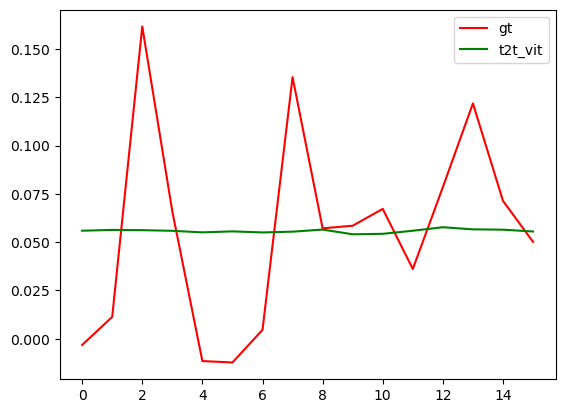

In [66]:
# t2t_vit
xpoints = np.array(range(16))
ypoints_0 = shap_values_t2t_vit_[0].numpy()

plt.plot(xpoints, ypoints_0, color='r', label='gt')
ypoints = shap_values_explainer['t2t_vit'][0].cpu().numpy()
plt.plot(xpoints, ypoints, color='g', label='t2t_vit')


plt.legend()
plt.show()

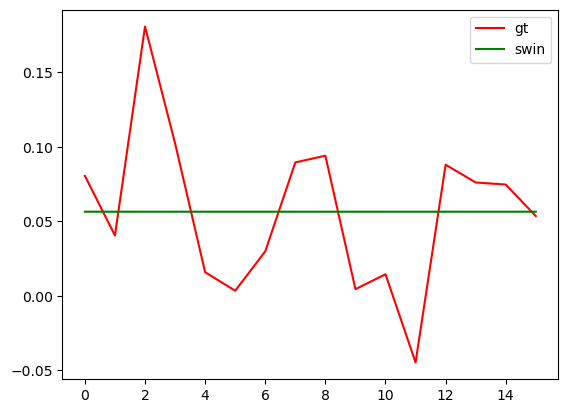

In [67]:
# t2t_vit
xpoints = np.array(range(16))
ypoints_0 = shap_values_swin_[0].numpy()

plt.plot(xpoints, ypoints_0, color='r', label='gt')
ypoints = shap_values_explainer['swin'][0].cpu().numpy()
plt.plot(xpoints, ypoints, color='g', label='swin')


plt.legend()
plt.show()

# Test best/worst/closest/furthest feature masking

In [11]:
from typing import Literal


def remake_masks(
    images: torch.Tensor,
    masks: torch.Tensor,
    targets: torch.Tensor,
    players_to_mask: Literal["best", "worst", "central", "peripheral", "random"],
    explainer: torch.nn.Module
) -> torch.Tensor:
    """
    Remake masks in a given batch according to a given strategy, keeping the same percentage of 0s and 1s.

    Args:
    - images: (B, C, H, W)
    - masks: (B, num_masks_per_image, num_players)
    - targets: (B,)
    - players_to_mask:
        - "best", "worst": mask (zero out) the players with the highest/lowest SHAP values for the target class, as estimated by the explainer.
        - "central", "peripheral": mask the players closest to/furthest from the center of the image.
        - "random": mask random players (resampled for each item in the batch).
    - explainer

    Returns new masks of shape (B, num_masks_per_image, explainer.surrogate.num_players)
    """
    B = images.shape[0]
    num_players = explainer.surrogate.num_players

    # From the masks in the batch we only take the percaentage of 0s and 1s.
    num_zeroes = masks.shape[2] - masks.sum(dim=2)  # (B, num_masks_per_image)
    # Rescale to the wanted number of players, keeping the same percentage of 0s and 1s.
    num_zeroes = (num_zeroes * num_players / masks.shape[2]).round()

    if players_to_mask in ["best", "worst"]:
        shap_values = explainer(images)  # (B, num_players, num_classes)
        # shap_values[b, p] := shap_values[b, p, targets[b]]
        shap_values = shap_values[torch.arange(shap_values.shape[0]), :, targets]  # (B, num_players)
        assert shap_values.shape == (B, num_players)
        return make_masks_from_player_values(num_zeroes=num_zeroes, player_values=shap_values, players_to_mask=players_to_mask)
    elif players_to_mask in ["central", "peripheral", "random"]:
        distances = get_distances_from_center(num_players).to(images.device).expand(B, num_players)
        if players_to_mask == "central":
            players_to_mask = "worst"
        elif players_to_mask == "peripheral":
            players_to_mask = "best"
        return make_masks_from_player_values(num_zeroes=num_zeroes, player_values=distances, players_to_mask=players_to_mask)
    else:
        raise ValueError(f"{players_to_mask=}")


def test_masked(surrogate: torch.nn.Module, dataloader: torch.utils.data.DataLoader, explainer: torch.nn.Module, players_to_mask: Literal["best", "worst", "random", "central", "peripheral"], device="cuda") -> None:
    results = []
    masked_percentages = []
    explainer.eval()
    surrogate.eval()
    with torch.no_grad():
        explainer.to(device)
        surrogate.to(device)
        correct, total = 0, 0
        with tqdm(dataloader, desc=players_to_mask) as dataloader_progress:
            for batch in dataloader_progress:
                images, masks, targets = batch['images'], batch['masks'], batch['labels']
                images, masks, targets = images.to(device), masks.to(device), targets.to(device)

                masks = remake_masks(images, masks, targets, players_to_mask, explainer).to(device)
                images, masks, targets = apply_masks_to_batch(images, masks, targets)

                logits = surrogate(images)
                _, predicted = logits.max(dim=1)
                total += targets.shape[0]
                correct += predicted.eq(targets).sum().item()
                results.extend(predicted.eq(targets).cpu().numpy())
                masked_percentages.extend((1 - masks.float()).mean(dim=1).cpu().numpy() * 100)
                dataloader_progress.set_postfix_str(f'Accuracy: {100.0 * correct / total:.2f}%')
    return pd.DataFrame({'result': results, 'masked %': masked_percentages})

all_results = {}

In [12]:
import IPython.display
import ipywidgets

def plot(all_results: dict[str, pd.DataFrame], bucket_size: float = 100 / 14) -> None:
    # Smooth the plot by rounding 'masked %' to the nearest multiple of bucket_size.
    plot_results = deepcopy(all_results)
    for k, df in plot_results.items():
       df['masked %'] = df['masked %'].div(bucket_size).round().astype(int).mul(bucket_size)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    for i, ax in enumerate(axs):
        for k, df in plot_results.items():
            ax.errorbar(
                x=list(df.groupby('masked %').groups.keys()),
                y=df.groupby('masked %').mean()["result"].to_list(),
                yerr=df.groupby('masked %').sem()["result"].mul(3).to_list(),
                label=k
            )
        ax.plot([0, 100], [0.97, 0.97], color='black', linestyle='dashed', linewidth=0.7, label='97%')
        ax.legend()
        ax.set_xlabel('masked %')
        ax.set_ylabel('accuracy')
        if i == 0:
            ax.set_xlim(0, 100)
            ax.set_ylim(0.4, 1)
        else:
            ax.set_xlim(0, 20)
            ax.set_ylim(0.9, 1)
    plt.show()

# Make a sub-output for updating the plot live.
plot_output = ipywidgets.Output()
IPython.display.display(plot_output)

with tqdm(range(2), desc="repeats") as repeats:
    for repeat in repeats:
        for players_to_mask in ["central", "peripheral", "random", "best", "worst"]:
            # Update plot
            plot_output.clear_output(wait=False)
            with plot_output:
                plot(all_results)
            # Test and update results
            df = test_masked(surrogate, datamodule.test_dataloader(), explainer, players_to_mask)
            if players_to_mask not in all_results:
                all_results[players_to_mask] = df
            else:
                all_results[players_to_mask] = pd.concat([all_results[players_to_mask], df])

# Update plot
plot_output.clear_output(wait=True)
with plot_output:
    plot(all_results)

Output()

repeats:   0%|          | 0/2 [00:00<?, ?it/s]

central:   0%|          | 0/313 [00:00<?, ?it/s]

peripheral:   0%|          | 0/313 [00:00<?, ?it/s]

random:   0%|          | 0/313 [00:00<?, ?it/s]

best:   0%|          | 0/313 [00:00<?, ?it/s]

worst:   0%|          | 0/313 [00:00<?, ?it/s]

central:   0%|          | 0/313 [00:00<?, ?it/s]

peripheral:   0%|          | 0/313 [00:00<?, ?it/s]

random:   0%|          | 0/313 [00:00<?, ?it/s]

best:   0%|          | 0/313 [00:00<?, ?it/s]

worst:   0%|          | 0/313 [00:00<?, ?it/s]